In [38]:
import os
import numpy as np
import matplotlib.pyplot as plt
# import torch
import plotly
import netCDF4
from datetime import datetime
from matplotlib.cm import get_cmap
import re
import pandas as pd
from shapely.geometry import Point, Polygon

LATITUDE_ORIGIN = 63.4269097
LONGITUDE_ORIGIN = 10.3969375
CIRCUMFERENCE = 40075000 # [m], circumference
circumference = CIRCUMFERENCE
def latlon2xy(lat, lon, lat_origin, lon_origin):
    x = np.deg2rad((lat - lat_origin)) / 2 / np.pi * CIRCUMFERENCE
    y = np.deg2rad((lon - lon_origin)) / 2 / np.pi * CIRCUMFERENCE * np.cos(np.deg2rad(lat))
    return x, y

# file = "/Users/yaolin/Library/CloudStorage/OneDrive-NTNU/MASCOT_PhD/Data/Nidelva/SINMOD_DATA/samples_2022.05.11.nc"
# figpath = "/Users/yaolin/HomeOffice/GOOGLE/Experiments/20220510/fig/"
# file = "/Users/yaolin/OneDrive - NTNU/MASCOT_PhD/Data/Nidelva/SINMOD_DATA/samples_2022.05.10.nc"
# figpath = "/Users/yaolin/HomeOffice/GOOGLE/Experiments/20220509/fig/"

FILEPATH = "/Users/yaoling/OneDrive - NTNU/MASCOT_PhD/Data/Nidelva/SINMOD_DATA/samples_2022.05.11.nc"
FIGPATH = "/Users/yaoling/HomeOffice/GOOGLE/Nidelva2D/fig/EDA/"
POLYGONPATH = "/Users/yaoling/HomeOffice/GOOGLE/Nidelva2D/Test/"
polygon_border = pd.read_csv(POLYGONPATH + "polygon_border.csv").to_numpy()
polygon_obstacle = pd.read_csv(POLYGONPATH + "polygon_obstacle.csv").to_numpy()
polygon_border_shapely = Polygon(polygon_border)
polygon_obstacle_shapely = Polygon(polygon_obstacle)

In [39]:
sinmod = netCDF4.Dataset(FILEPATH)

In [40]:
ind_before = re.search("samples_", FILEPATH)
ind_after = re.search(".nc", FILEPATH)
date_string = FILEPATH[ind_before.end():ind_after.start()]
ref_timestamp = datetime.strptime(date_string, "%Y.%m.%d").timestamp()
timestamp = np.array(sinmod["time"]) * 24 * 3600 + ref_timestamp #change ref timestamp
lat_sinmod = np.array(sinmod['gridLats'])
lon_sinmod = np.array(sinmod['gridLons'])
depth_sinmod = np.array(sinmod['zc'])
salinity_sinmod = np.array(sinmod['salinity'])


In [41]:
from shapely.geometry import Point, Polygon
import matplotlib.tri as tri

def is_masked(lat, lon, polygon_border=None, polygon_obstacle=None):
    point = Point(lat, lon)
    masked = False
    if polygon_obstacle.contains(point) or not polygon_border.contains(point):
        masked = True
    return masked


def plotf_vector(lon, lat, values, title=None, alpha=None, cmap=get_cmap("BrBG", 10), cbar_title='test', colorbar=True,
                 vmin=None, vmax=None, ticks=None, stepsize=None, threshold=None, polygon_border=None, polygon_obstacle=None,
                 xlabel=None, ylabel=None):

    triangulated = tri.Triangulation(lon, lat)
    lon_triangulated = lon[triangulated.triangles].mean(axis=1)
    lat_triangulated = lat[triangulated.triangles].mean(axis=1)

    ind_mask = []
    for i in range(len(lon_triangulated)):
        ind_mask.append(is_masked(lat_triangulated[i], lon_triangulated[i], Polygon(polygon_border),
                                  Polygon(polygon_obstacle)))
    triangulated.set_mask(ind_mask)
    refiner = tri.UniformTriRefiner(triangulated)
    triangulated_refined, value_refined = refiner.refine_field(values.flatten(), subdiv=3)

    ax = plt.gca()
    # ax.triplot(triangulated, lw=0.5, color='white')
    if np.any([vmin, vmax]):
        levels = np.arange(vmin, vmax, stepsize)
    else:
        levels = None

    # print("levels: ", levels)

    if np.any(levels):
        linewidths = np.ones_like(levels) * .3
        colors = len(levels) * ['black']
        if threshold:
            dist = np.abs(threshold - levels)
            ind = np.where(dist == np.amin(dist))[0]
            linewidths[ind] = 3
            colors[ind[0]] = 'red'
        contourplot = ax.tricontourf(triangulated_refined, value_refined, levels=levels, cmap=cmap, alpha=alpha)
        ax.tricontour(triangulated_refined, value_refined, levels=levels, linewidths=linewidths, colors=colors,
                      alpha=alpha)
    else:
        contourplot = ax.tricontourf(triangulated_refined, value_refined, cmap=cmap, alpha=alpha)
        ax.tricontour(triangulated_refined, value_refined, vmin=vmin, vmax=vmax, alpha=alpha)

    if colorbar:
        cbar = plt.colorbar(contourplot, ax=ax, ticks=ticks)
        cbar.ax.set_title(cbar_title)
    # plt.plot(knowledge.polygon_border_xy[:, 1], knowledge.polygon_border_xy[:, 0], 'k-', linewidth=1)
    # plt.plot(knowledge.polygon_obstacle_xy[:, 1], knowledge.polygon_obstacle_xy[:, 0], 'k-', linewidth=1)
    # plt.plot(knowledge.starting_location.y, knowledge.starting_location.x, 'kv', ms=10)
    # plt.plot(knowledge.goal_location.y, knowledge.goal_location.x, 'rv', ms=10)
    plt.xlim([np.amin(lon), np.amax(lon)])
    plt.ylim([np.amin(lat), np.amax(lat)])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.plot(polygon_border[:, 1], polygon_border[:, 0], 'k-.', lw=2)
    plt.plot(polygon_obstacle[:, 1], polygon_obstacle[:, 0], 'k-.', lw=2)

    # plt.show()

In [42]:
for i in range(salinity_sinmod.shape[0]):
    print(i)
    plt.figure(figsize=(12, 10))
    plotf_vector(lon=lon_sinmod.flatten(), lat=lat_sinmod.flatten(), values=salinity_sinmod[i, 0, :, :],
                 title="SINMOD surface salinity estimation on " + datetime.fromtimestamp(timestamp[i]).strftime("%H:%M:%S, %Y-%m-%d"),
                 alpha=None, cmap=get_cmap("BrBG", 10), cbar_title='Salinity', colorbar=True,
                 vmin=10, vmax=32, ticks=None, stepsize=2, threshold=26.8, polygon_border=polygon_border,
                 polygon_obstacle=polygon_obstacle,
                 xlabel="Lon [deg]", ylabel="Lat [deg]")
    # plt.plot(polygon_border[:, 1], polygon_border[:, 0], 'k-.')
    # plt.plot(polygon_obstacle[:, 1], polygon_obstacle[:, 0], 'k-.')
    # plt.scatter(lon_sinmod, lat_sinmod, c=salinity_sinmod[i, 0, :, :], cmap=get_cmap("BrBG", 10), vmin=10, vmax=30)
    # plt.xlabel("Lon [deg]")
    # plt.ylabel("Lat [deg]")
    # plt.title("SINMOD Surface Salinity Estimation on " + datetime.fromtimestamp(timestamp[i]).strftime("%H:%M:%S"))
    # plt.colorbar()
    plt.ylim([63.43, 63.475])
    plt.xlim([10.34, 10.44])
    plt.savefig(FIGPATH+"sinmod/P_{:03d}.jpg".format(i), dpi=300)
    # plt.show()
    plt.close("all")
    # break


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119


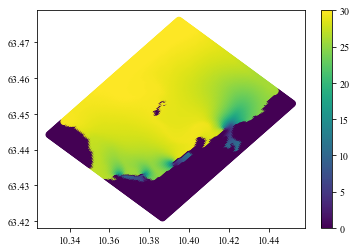

In [51]:
lon = lon_sinmod.flatten()
lat = lat_sinmod.flatten()
values=salinity_sinmod[0, 0, :, :].flatten()

plt.scatter(lon, lat, c=values, vmin=0, vmax=30)
plt.colorbar()
df = pd.DataFrame(np.vstack((lat, lon, values)).T, columns=['lat', 'lon', 'salinity'])
df.to_csv(FIGPATH + "sinmod.csv", index=False)

In [52]:
df.shape

(17731, 3)

ModuleNotFoundError: No module named '_tkinter'

/bin/bash: pip: command not found
